### Introduction

**What are nuclear features?** 🔬 Nuclear features are quantitative measurements of individual nuclei that provide a deeper understanding of their biology and pathology. Histolytics organizes these features into four main categories: shape (morphometrics), intensity, chromatin distribution, and textural features. These features can be used to quantify nuclear pleomorphism, a term used in histopathology to describe a significant variation in the size, shape, and staining of nuclei.

**Shape (Morphometrics):** These features describe a nucleus's physical form and dimensions. Analyzing these can help you identify changes in cell state, as a cell undergoing transformation or experiencing stress often changes its nuclear shape and size. These metrics are efficiently computed directly from the vectorized segmentation masks.

**Intensity Features:** These metrics, based on the pixel values within a nucleus, are crucial for quantifying staining patterns which can indicate differences in a cell's state.

**Chromatin Distribution Features:** This category quantifies the spatial organization of chromatin within nuclei, which is a key indicator of cellular state. A change in chromatin distribution often signals a shift in cell function or an impending disease process.

**Textural Features:** These features describe the texture of the nuclear interior, capturing subtle patterns that are difficult for the human eye to detect.

We will demonstrate how to compute these features, starting by computing the morphometric features:

,geometry,class_name
0,"POLYGON ((1394.01 0, 1395.01 1.99, 1398 3.99, ...",connective
1,"POLYGON ((1391 2.01, 1387 2.01, 1384.01 3.01, ...",connective
2,"POLYGON ((1382.99 156.01, 1380 156.01, 1376.01...",connective
3,"POLYGON ((1321 170.01, 1317.01 174.01, 1312.01...",connective
4,"POLYGON ((1297.01 0, 1299.01 2.99, 1302 5.99, ...",connective


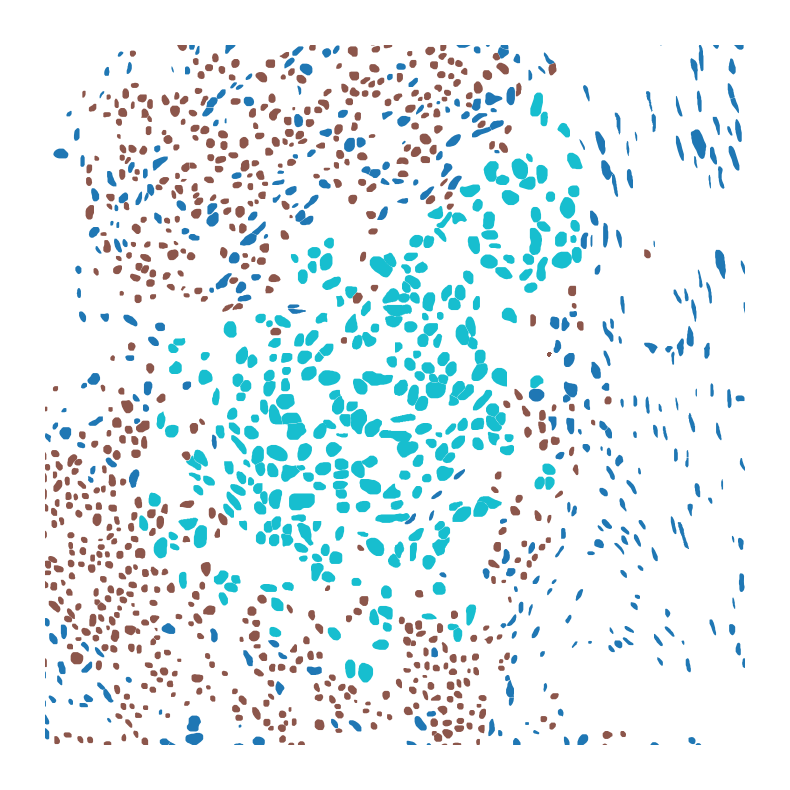

In [1]:
from histolytics.data import hgsc_cancer_he, hgsc_cancer_nuclei

# Load some example data
nuc = hgsc_cancer_nuclei()  # Nuclei vector segmentation
he = hgsc_cancer_he()  # Corresponding H&E image

ax = nuc.plot(figsize=(10, 10), column="class_name")
ax.set_axis_off()
nuc.head(5)

### Morphometrics

To compute the nuclear morphometrics, you can use the `shape_metric`-function. The allowed morphometrics to compute are: "area", "perimeter", "major_axis_len", "minor_axis_len", "major_axis_angle", "minor_axis_angle", "compactness", "circularity", "convexity", "solidity", "elongation", "eccentricity", "fractal_dimension", "sphericity", "shape_index", "rectangularity", "squareness", "equivalent_rectangular_index",

In biological context, possibly the most interesting morphometrics are the area, eccentricity/elongation, compactness and in some cases the fractal dimension. These are good descriptors of shape pleomorphism that try to describe the variability in nuclear shape and size. Despite of this, the choice of features to compute will ultimately depend on the specific biological question being addressed. Since we are not addressing any specific question here, we'll compute all the possible morphometrics for demonstration purposes:

In [2]:
from histolytics.spatial_geom.shape_metrics import shape_metric

metrics = [
    "major_axis_len",
    "minor_axis_len",
    "major_axis_angle",
    "minor_axis_angle",
    "compactness",
    "circularity",
    "convexity",
    "solidity",
    "elongation",
    "eccentricity",
    "fractal_dimension",
    "shape_index",
    "rectangularity",
    "squareness",
    "equivalent_rectangular_index",
    "area",
    "perimeter",
]

nuc = shape_metric(nuc, metrics=metrics, num_processes=3)
nuc.head(3)

,geometry,class_name,area,perimeter,major_axis_len,minor_axis_len,major_axis_angle,minor_axis_angle,compactness,circularity,convexity,solidity,elongation,eccentricity,fractal_dimension,shape_index,rectangularity,squareness,equivalent_rectangular_index
0,"POLYGON ((1394.01 0, 1395.01 1.99, 1398 3.99, ...",connective,36.06900,27.986316,12.220000,3.990000,0.000000,90.000000,0.578699,0.578699,1.000000,1.000000,0.326514,9.451924e-01,1.085180,0.554563,0.739759,0.736822,0.742468
1,"POLYGON ((1391 2.01, 1387 2.01, 1384.01 3.01, ...",connective,182.46535,49.205771,14.980000,14.980000,0.000000,90.000000,0.947018,0.947018,1.000000,1.000000,1.000000,5.161914e-08,0.964059,0.856464,0.813124,1.205781,0.740496
2,"POLYGON ((1382.99 156.01, 1380 156.01, 1376.01...",connective,231.95650,69.421231,30.729437,9.590079,78.690068,11.309932,0.604828,0.608743,0.996779,0.972191,0.366122,9.500554e-01,1.047966,0.559090,0.787100,0.770091,0.763769


### Intensity Features

While morphometric features can be computed directly from the vectorized segmentation maps, the rest of the feature categories (intensity, chromatin, and textural) require the underlying pixel data from the H&E image.

To compute these features you need to [rasterize](../vector_to_raster/) the input segmentation masks. Histolytics uses this raster mask to isolate the corresponding pixels from the H&E image and computes the desired features on those isolated pixels. 

In this section, we will cover the intensity features that can be extracted from the H&E image and corresponding raster label mask. These features are extracted with functions: `grayscale_intensity_feats` and `rgb_intensity_feats`. NOTE that you can use gpu acceleration to compute these features by providing parameter `device="cuda"`.

The allowed intensity metrics per nuclei are: "min", "max", "mean", "median", "std", "quantiles", "meanmediandiff", "mad", "iqr", "skewness", "kurtosis", "histenergy"

In biological context, possibly the most interesting intensity features are just the mean/median and standard deviation of the intensity values within each nuclear region. These features can provide insights into the heterogeneity and overall intensity distribution within the nuclei. These features can be useful for example when quantifying the level of chromatism (hyper/hypo) that has direct implications for tumor biology. But again, the choice of features to compute will ultimately depend on the specific biological question being addressed. So for the sake of the example, we'll compute all the possible features:

In [3]:
from histolytics.utils.raster import gdf2inst
from histolytics.nuc_feats.intensity import (
    rgb_intensity_feats,
    grayscale_intensity_feats,
)


# convert the nuclei gdf into raster mask
inst_mask = gdf2inst(nuc, width=he.shape[1], height=he.shape[0])

metrics = [
    "min",
    "max",
    "mean",
    "median",
    "std",
    "quantiles",
    "meanmediandiff",
    "mad",
    "iqr",
    "skewness",
    "kurtosis",
    "histenergy",
]

gr_intensity_feats = grayscale_intensity_feats(
    he, inst_mask, metrics=metrics, device="cuda"
)
gr_intensity_feats.head(3)

,min,max,mean,median,std,quantile_0.25,quantile_0.5,quantile_0.75,meanmediandiff,mad,iqr,skewness,kurtosis,histenergy
1,0.032768,0.207166,0.088276,0.067679,0.046387,0.052129,0.067679,0.125847,0.020597,0.024256,0.073719,0.850163,-0.428480,0.262632
2,0.085619,0.317818,0.187696,0.177222,0.058691,0.138690,0.177222,0.237239,0.010474,0.044008,0.098549,0.352018,-0.973655,0.158222
3,0.119424,0.391479,0.207000,0.194400,0.055537,0.163815,0.194400,0.247490,0.012600,0.037783,0.083675,0.798506,0.408790,0.168847


In [4]:
# compute the same features for every rgb channel separately
rgb_intensity_feats = rgb_intensity_feats(he, inst_mask, metrics=metrics, device="cuda")
rgb_intensity_feats.head(3)

,R_min,R_max,R_mean,R_median,R_std,R_quantile_0.25,R_quantile_0.5,R_quantile_0.75,R_meanmediandiff,R_mad,...,B_std,B_quantile_0.25,B_quantile_0.5,B_quantile_0.75,B_meanmediandiff,B_mad,B_iqr,B_skewness,B_kurtosis,B_histenergy
1,0.081897,0.379310,0.199215,0.193966,0.071971,0.142241,0.193966,0.260776,0.005249,0.056034,...,0.098219,0.297414,0.375000,0.448276,0.002288,0.077586,0.150862,0.134831,-0.777452,0.085671
2,0.232759,0.474138,0.350049,0.340517,0.063733,0.295259,0.340517,0.400862,0.009532,0.051724,...,0.049941,0.525862,0.560345,0.599138,0.000703,0.038793,0.073276,0.013264,-0.852830,0.161521
3,0.288793,0.538793,0.368869,0.357759,0.051170,0.335129,0.357759,0.400862,0.011110,0.034483,...,0.070186,0.491379,0.521552,0.575431,0.016387,0.038793,0.084052,0.918229,0.485612,0.136296


###

### Chromatin Distribution Features

Next up, we'll extract chromatin distribution features from the H&E image and corresponding raster label mask. These are extracted with the `chromatin_feats`-function and can provide insights into the spatial organization and distribution of chromatin within the nuclei. For example, is the chromatin dispersed at the boundaries or covering the full nuclei.

The allowed features are:

- "chrom_area" - The chromatin clump area
- "chrom_nuc_prop" - The proportion of chromatin area to full nucleus area
- "n_chrom_clumps" - The number of chromatin clumps
- "chrom_boundary_prop" - The proportion of chromatin clump area to the nucleus boundary area
- "manders_coloc_coeff" - The Manders' colocalization coefficient for the nucleus and chromatin clump intensity values

In biological context, all these features can provide valuable information about the chromatin organization within the nuclei and may be relevant for understanding various biological processes. For example, detecting Orphan Annie eye nuclei (chromatin dispersed at the nucleus boundaries whereas rest of the nucleus is optically clear), or hyper/hyochromatism.

In [5]:
from histolytics.nuc_feats.chromatin import chromatin_feats

metrics = [
    "chrom_area",
    "chrom_nuc_prop",
    "n_chrom_clumps",
    "chrom_boundary_prop",
    "manders_coloc_coeff",
]

# compute chromatin distribution features
chrom_feats = chromatin_feats(he, inst_mask, metrics=metrics, device="cuda")
chrom_feats.head(3)

,chrom_area,chrom_nuc_prop,n_chrom_clumps,chrom_boundary_prop,manders_coloc_coeff
1,139,0.776536,1.0,0.471545,0.657315
2,41,0.180617,1.0,0.016484,0.130406
3,5,0.043103,3.0,0.027273,0.030922


#### Visualizing Chromatin Clump Segmentations

Internally, the `chromatin_feats`-function segments the chromatin clumps within the nuclei using the `histolytics.nuc_feats.chromatin.extract_chromatin_clumps` function. To see what the chromatin clump segmentations look like, we can visualize them followingly:

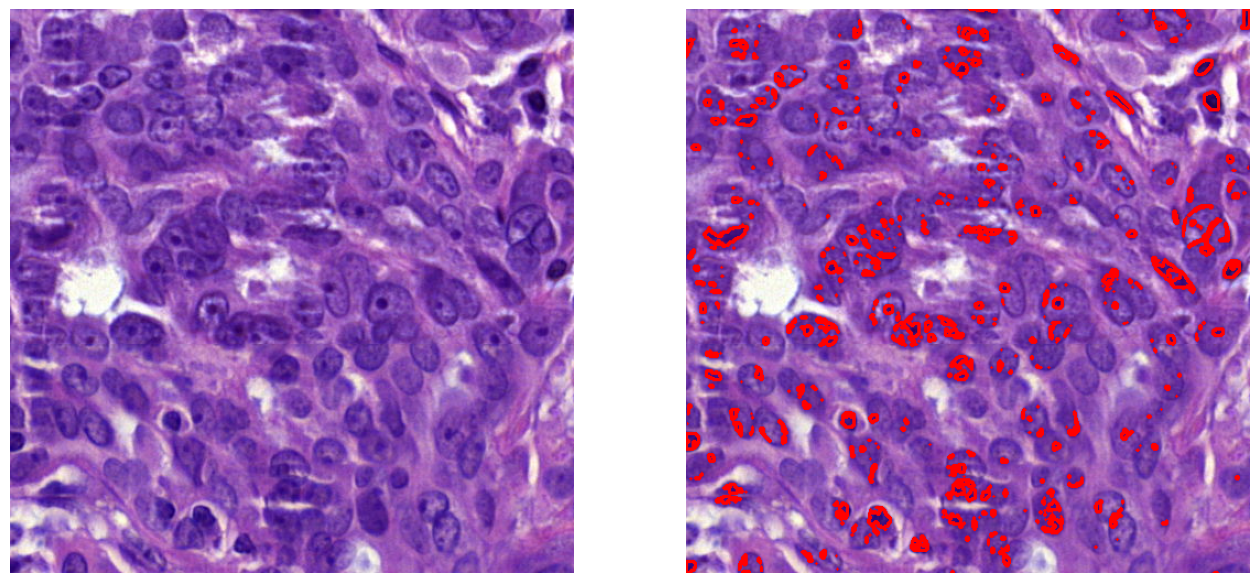

In [6]:
import matplotlib.pyplot as plt
from skimage.measure import label
from histolytics.nuc_feats.chromatin import extract_chromatin_clumps
from histolytics.utils.plot import draw_thing_contours

# extract the chromatin clumps
chrom_mask = extract_chromatin_clumps(he, inst_mask, device="cuda")

# Let's crop a region from the center to see the chromatin clumps better
h, w = chrom_mask.shape
crop_size = 512
start_y = (h - crop_size) // 2
start_x = (w - crop_size) // 2

chrom_mask_crop = chrom_mask[
    start_y : start_y + crop_size, start_x : start_x + crop_size
]
he_crop = he[start_y : start_y + crop_size, start_x : start_x + crop_size]

# Let's plot the chromatin clumps
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
contours = draw_thing_contours(he_crop, label(chrom_mask_crop), chrom_mask_crop)
ax[0].imshow(he_crop)
ax[0].set_axis_off()
ax[1].imshow(contours)
ax[1].set_axis_off()

### Textural Features

The textural features are based on the Gray Level Co-occurrence Matrix (GLCM), which is a statistical method of examining texture that considers the spatial relationship of pixels. The following textural features are extracted:

- **Contrast**: Measures the intensity contrast between a pixel and its neighbor over the whole image.
- **Dissimilarity**: Measures the variation in the gray level co-occurrence matrix.
- **Homogeneity**: Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.
- **Energy**: Measures the uniformity of the GLCM.
- **Entropy**: Measures the amount of information that is missing from the image.

In a biological context, these features can reveal textural patterns of the chromatin staining.

For example, the contrast and dissimilarity can measure the coarseness and heterogeneity of the nuclear texture. High values can indicate a coarse, clumpy chromatin pattern.

Homogeneity and energy can measure the uniformity of the nuclear texture. High values suggest a smooth and orderly chromatin distribution, while low values point to a more disordered or disorganized pattern.

The entropy, on the other hand, quantifies the randomness and complexity of the nuclear texture. High entropy is strongly associated with chaotic chromatin patterns.

The feature computation is based on the skimage library, you can see their [documentation](https://scikit-image.org/docs/0.25.x/api/skimage.feature.html#skimage.feature.graycoprops) for more info about GLCM features.

In [7]:
from histolytics.nuc_feats.texture import textural_feats

metrics = ["contrast", "dissimilarity"]
distances = (1,)
angles = (0,)

tex_feats = textural_feats(
    he,
    inst_mask,
    distances=distances,
    metrics=metrics,
    angles=angles,
    device="cuda",
)

tex_feats.head(3)

,contrast_d-1_a-0.00,dissimilarity_d-1_a-0.00
1,193.428571,6.628571
2,603.786667,11.600000
3,711.378788,11.934343
